<a href="https://colab.research.google.com/github/0xbadc0ffe/DeepChaos/blob/main/DeepChaos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Chaos

In [1]:
#@title Utilities and Imports

from re import S
from typing import Union, Optional,  Optional, Callable, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import os
import random
import json
import plotly.express as px

#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# reproducibility stuff
if True:
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(0)
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
    torch.backends.cudnn.benchmark = False


def count_parameters(model: torch.nn.Module) -> int:
  """ Counts the number of trainable parameters of a module
  
  :param model: model that contains the parameters to count
  :returns: the number of parameters in the model
  """
  return sum(p.numel() for p in model.parameters() if p.requires_grad)


def lin_sys(x, A, b):
    y = torch.einsum("ik, k -> i", A, x)
    y = y + b
    return y


class ESN(nn.Module):
    def __init__(
        self, Win:torch.Tensor, W:torch.Tensor, activation:str, output_size: int
    ) -> None:
        
        super().__init__()
        #self.fci = nn.Linear(input_size, in_to_hidden)
        self.Win = Win
        self.W = W
        self.activation = activation
        self.ker_size = 10

        if activation == "LeakyReLU":
            self.act = torch.nn.LeakyReLU()
        elif activation == "Tanh":
            self.act = torch.nn.Tanh()
        elif  activation == "ELU":
            self.act = torch.nn.ELU(alpha=1.0, inplace=False)
        elif activation == "ModTanh":
            self.mod = nn.Linear(W.shape[0], 1)
            self.act = torch.nn.Tanh()
        elif activation == "PrModTanh":
            self.mod = nn.Linear(W.shape[0], 1)
            self.act = torch.nn.Tanh()
        elif activation == "ConvModTanh1" or activation == "ConvModTanh2":
            self.mod2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(W.shape[0],1))
            self.mod3 = nn.Linear(W.shape[0],1)
            self.act = torch.nn.Tanh()
        else:   
            # Default activation function
            self.act = torch.nn.Tanh()

        self.fco = nn.Linear(W.shape[0], output_size)

        #self.mod2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=self.ker_size)#max(3,W.shape[0]//20))
        #self.mod3 = nn.Linear((W.shape[0]-self.ker_size+1),1)

        #self.mod4 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(W.shape[0],1))
        #self.mod5 = nn.Linear(W.shape[0],1)

    def forward(self, 
                u: torch.Tensor, 
                h_i: torch.Tensor
        ) -> torch.Tensor:

        #x = self.fci(u)
        xu = torch.einsum("ik, k -> i", self.Win, u)
        #x, h_o = self.resvoir(x, h_i)
        x = xu + torch.einsum("ij, j -> i", self.W, h_i)
        #h_o = torch.tanh(x)   # x(n+1) = tanh(Win*u(n) +  W*x(n))
        h_o = self.act(x)

        if self.activation == "ModTanh":
            h_o = (torch.tanh(self.mod(h_o))+1)*h_o  

        elif self.activation == "PrModTanh":
            pr = torch.tanh(torch.einsum("ij, j -> i", self.W, h_o) +  torch.einsum("ik, k -> i", self.Win, self.fco(h_o)))
            h_o = (torch.tanh(self.mod(pr))+1)*h_o

        elif self.activation == "ConvModTanh1":
            h_conv = torch.einsum("ij, j -> i", self.W, h_o) 
            h_conv = torch.einsum("i, ij, k-> jk", h_o, self.W, h_conv)
            h_conv = self.mod2(torch.reshape(h_conv,(1,1,W.shape[0],W.shape[0])))[0,0,0,...]
            h_o = (torch.tanh(self.mod3(h_conv))+1)*h_o

        elif self.activation == "ConvModTanh2":
            h_conv= self.W*h_o
            h_conv = self.mod2(torch.reshape(h_conv,(1,1,W.shape[0],W.shape[0])))[0,0,0,...]
            h_o = (torch.tanh(self.mod3(h_conv))+1)*h_o

        #h_conv = torch.einsum("ij, j -> i", self.W, h_i) 
        #h_conv = torch.einsum("i, ij, k-> jk", h_i, self.W, h_conv)
        
        #h_conv = self.mod2(torch.reshape(h_conv,(1,1,1000,1000)))[0,0,...]
        #h_o = (torch.tanh(self.mod3(torch.diag(h_conv)))+1)*h_o

        #h_conv = self.mod2(torch.reshape(h_conv,(1,1,1000,1000)))[0,0,...]
        #h_conv = F.max_pool2d(h_conv, kernel_size=self.ker_size)
        #h_o = (torch.tanh(self.mod3(h_conv))+1)*h_o

        x = self.fco(h_o)

        return x, h_o


def get_model_optimizer(model: torch.nn.Module, opt_type:str) -> torch.optim.Optimizer:
    """
    Encapsulate the creation of the model's optimizer, to ensure that we use the
    same optimizer everywhere

    :param model: the model that contains the parameter to optimize

    :returns: the model's optimizer
    """
    if opt_type == "Adam":
        return optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    elif opt_type == "SGD":
        return optim.SGD(model.parameters(), lr=0.01, momentum=0.1, weight_decay=1e-5)
    else:
        # default
        return optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


# Fast Largest Eigenvector
def FLE(A, iters=500, eigvec=False):
    v = torch.ones(A.shape[0]) #.to(device)
    for _ in range(iters):
        m = torch.einsum("ij, j -> i",A, v)
        lamb = torch.norm(m)
        v = m/lamb
    if eigvec:
        return torch.norm(torch.einsum("ij, j -> i",A, v)), v
    else:
        return torch.norm(torch.einsum("ij, j -> i",A, v))

# Slow Largest Eigenvector
def SLE(A):
    eig = torch.linalg.eig(A)[0]
    eig = eig.unsqueeze(1)
    return torch.max(torch.norm(eig, dim=1))


def set_reproducibility(seed=42):
    # reproducibility stuff
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(0)
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
    torch.backends.cudnn.benchmark = False


def sigm(x, k=1):
    return 1/(1 + np.exp(-k*x))

# lw and rw tune how much the distribution stays with mean 1 and N
# (we are using the sigmoid(x) for x in [lw,rw]). 
# Lower lw => more epochs with mean 1, higher rw => more epochs with mean around N.
# ek tune the slope of the sigmoid distribution (lower ek => smaller slope).
# estd = 0.5 or 0.7 power law of the std
# N is the maximum value to reach
def curriculum_gen(k,K,N, lw=-7, rw=4, ek=0.85, estd=0.5):
    ran = N+1
    while ran > N:
        mean = sigm((K-k)/K*lw + k/K*rw, ek)*N
        ran = 1 + abs(np.random.normal(mean,(N*k/K)**estd))
        ran = int(ran)
    return ran


# Exectue curriculum_gen "cycles" times
# cycles span grow as x/(max(1, log(x)-3))
def phased_gen(k, K, N, cycles=None, lw=-7, rw=4, ek=0.85, estd=0.5):
    if cycles is None:
        cycles = max(1, int(np.log(K))-3) #-2.6
        #cycles = max(1, K//500)
    Kc = K/cycles
    ran = curriculum_gen(k%Kc,Kc,N, lw=-7, rw=4, ek=0.85, estd=0.5)
    return ran
        

In [2]:
#@title Saving Utilities

PATH = os.path.abspath(".\data")

def load(mod_name="model", jfile="cfgs", path=PATH):
    model_dict = None
    data = None
    plots = None
    try:
        data =  load_cfgs(jfile, path)
        model_dict = load_model_dict(mod_name,path)
        plots = load_plot_data(path)
    except Exception as e:
        #print(e)
        return False, model_dict, data, plots
    return True, model_dict, data, plots

def load_plot_data(path=PATH):
    plots = {}
    plots["loss"] = torch.load(path + "\\loss.pt")
    plots["weigths_norm"] = torch.load(path + "\\weigths_norm.pt")
    plots["ground_truth_sys"] = torch.load(path + "\\ground_truth_sys.pt")
    plots["1-forecasting"] = torch.load(path + "\\1-forecasting.pt")
    plots["n-forecasting"] = torch.load(path + "\\n-forecasting.pt")
    plots["trained-forecasting"] = torch.load(path + "\\trained-forecasting.pt")
    return plots

def load_cfgs(name="cfgs", path=PATH):
    with open(path +f"\{name}.json", "r") as jfile:
        return json.load(jfile)

def load_model_dict(name="model",path=PATH):
    return torch.load(path + f"\{name}.pth")

def save_hidden(h_0, name="h_0", path=PATH):
    torch.save(h_0, path + f"\{name}.pt")

def load_hidden(name="h_0", path=PATH):
    return torch.load(path + f"\{name}.pt")

def save_initial(x_0, name="x_0", path=PATH):
    torch.save(x_0, path + f"\{name}.pt")

def load_initial(name="x_0", path=PATH):
    return torch.load(path + f"\{name}.pt")

def save_W(W, name="W", path=PATH):
    torch.save(W, path + f"\{name}.pt")

def load_W(name="W", path=PATH):
    return torch.load(path + f"\{name}.pt")

def save_Win(Win, name="Win", path=PATH):
    torch.save(Win, path + f"\{name}.pt")

def load_Win(name="Win", path=PATH):
    return torch.load(path + f"\{name}.pt")

# TODO: Save System (and x_0 togheter)
# TODO: Save W_in, W, h_0 togheter

def save(model, data, plots: dict, model_name="model", cfgs_name="cfgs", path=PATH):

    # Saving model weights
    torch.save(model.state_dict(), path+f"\{model_name}.pth")

    # Saving plots and configs
    jsonfile = path+f"\{cfgs_name}.json"
    
    with open(jsonfile, "w+") as jfile:
        json.dump(data, jfile, indent=4)

    # saving plots
    for name in plots:
        torch.save(plots[name], path + f"\{name}.pt")


In [3]:
#@title Model

def build_ESN(H=200, d=3, lambda_coeff=0.4, dym_sys=3, sigma_in=0.15, activation="Tanh", output_size="3", device="cpu"):
    model = ESN()
    model.build_model(H, d, lambda_coeff, dym_sys, sigma_in, activation, output_size=output_size, device=device)
    return model


class ESN(nn.Module):
    def __init__(
        self, Win:torch.Tensor=None, W:torch.Tensor=None, activation:str = "Tanh", output_size: int = 3, h_0:torch.Tensor=None
    ) -> None:
        
        super().__init__()
        self.Win = Win
        self.W = W
        self.activation = activation
        self.h = h_0

        if W is None:
            return

        if activation == "LeakyReLU":
            self.act = torch.nn.LeakyReLU()
        elif activation == "Tanh":
            self.act = torch.nn.Tanh()
        elif  activation == "ELU":
            self.act = torch.nn.ELU(alpha=1.0, inplace=False)
        elif activation == "ModTanh":
            self.mod = nn.Linear(W.shape[0], 1)
            self.act = torch.nn.Tanh()
        elif activation == "PrModTanh":
            self.mod = nn.Linear(W.shape[0], 1)
            self.act = torch.nn.Tanh()
        elif activation == "ConvModTanh1" or activation == "ConvModTanh2":
            self.mod2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(W.shape[0],1))
            self.mod3 = nn.Linear(W.shape[0],1)
            self.act = torch.nn.Tanh()
        else:   
            # Default activation function
            self.act = torch.nn.Tanh()

        self.fco = nn.Linear(W.shape[0], output_size)


    def forward(self, 
                u: torch.Tensor, 
                h_i: torch.Tensor
        ) -> torch.Tensor:

        #x = self.fci(u)
        xu = torch.einsum("ik, k -> i", self.Win, u)
        #x, h_o = self.resvoir(x, h_i)
        x = xu + torch.einsum("ij, j -> i", self.W, h_i)
        #h_o = torch.tanh(x)   # x(n+1) = tanh(Win*u(n) +  W*x(n))
        h_o = self.act(x)

        if self.activation == "ModTanh":
            h_o = (torch.tanh(self.mod(h_o))+1)*h_o  

        elif self.activation == "PrModTanh":
            pr = torch.tanh(torch.einsum("ij, j -> i", self.W, h_o) +  torch.einsum("ik, k -> i", self.Win, self.fco(h_o)))
            h_o = (torch.tanh(self.mod(pr))+1)*h_o

        elif self.activation == "ConvModTanh1":
            h_conv = torch.einsum("ij, j -> i", self.W, h_o) 
            h_conv = torch.einsum("i, ij, k-> jk", h_o, self.W, h_conv)
            h_conv = self.mod2(torch.reshape(h_conv,(1,1,self.W.shape[0],self.W.shape[0])))[0,0,0,...]
            h_o = (torch.tanh(self.mod3(h_conv))+1)*h_o

        elif self.activation == "ConvModTanh2":
            h_conv= self.W*h_o
            h_conv = self.mod2(torch.reshape(h_conv,(1,1,self.W.shape[0],self.W.shape[0])))[0,0,0,...]
            h_o = (torch.tanh(self.mod3(h_conv))+1)*h_o


        x = self.fco(h_o)

        return x, h_o

    # like forward but handle the hidden state internnally
    def step(self, u: torch.Tensor )-> torch.Tensor:
        x, h_i = self.forward(u, self.h)
        self.h = h_i
        return x, h_i

    def init_reservoir(self, H=200, d=3, lambda_coeff=0.4, device="cpu"): 
        self.H = H         
        W = torch.rand([H,H])*2 - 1
        ind = np.diag_indices(W.shape[0])
        W[ind[0],ind[1]] = 0
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                if torch.rand(1) > d/(H-1):
                    W[i,j] = 0
        cnt = 0
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                if abs(W[i,j]) > 0:
                    cnt += 1

        self.connectivity = cnt/H

        # Forcing largest eigenvalue norm to lambda to ensure ESP
        eig = SLE(W) #FLE(W)
        W = W*lambda_coeff/eig
        W.to(device)
        self.W = W

    def init_Win(self, H=None, dym_sys=3, sigma_in=0.15, device="cpu"):
        if H is None:
            H = self.H
        In_acc = (torch.rand([H], device=device)*2 - 1)*sigma_in
        h_0 = torch.rand([H], device=device)
        Win = torch.zeros([H,dym_sys], device=device)
        for i in range(In_acc.shape[0]):
            Win[i,torch.randint(high=dym_sys, size=[1], device=device)] = In_acc[i]
        self.Win = Win

    def set_activation(self, activation, H=None, device="cpu"): 

        if H is None:
            H = self.H

        self.activation = activation  
        if activation == "LeakyReLU":
            self.act = torch.nn.LeakyReLU()
        elif activation == "Tanh":
            self.act = torch.nn.Tanh()
        elif  activation == "ELU":
            self.act = torch.nn.ELU(alpha=1.0, inplace=False)
        elif activation == "ModTanh":
            self.mod = nn.Linear(H, 1, device=device)
            self.act = torch.nn.Tanh()
        elif activation == "PrModTanh":
            self.mod = nn.Linear(H, 1, device=device)
            self.act = torch.nn.Tanh()
        elif activation == "ConvModTanh1" or activation == "ConvModTanh2":
            self.mod2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(H,1), device=device)
            self.mod3 = nn.Linear(H,1, device=device)
            self.act = torch.nn.Tanh()
        else:   
            # Default activation function
            self.act = torch.nn.Tanh()

    def set_fc_output(self, output_size=3, H=None, device="cpu"):
        if H is None:
            H = self.H
        self.fco = nn.Linear(H, output_size, device=device)

    def build_model(self, H=200, d=3, lambda_coeff=0.4, dym_sys=3, sigma_in=0.15, activation="Tanh", output_size="3", device="cpu"):
        self.init_reservoir(H=H, d=d, lambda_coeff=lambda_coeff, device=device)
        self.init_Win(dym_sys=dym_sys, sigma_in=sigma_in, device=device)
        self.set_activation(activation, device=device)
        self.set_fc_output(output_size, device=device)

    def rand_h0(self, range=1,H=None, device="cpu"):
        if H is None:
            H = self.H
        self.h_0 = (torch.rand([H], device=device)*2-1)*range
        return self.h_0
        

In [4]:
#@title Systems emulation utilities


def Lorenz(t, x, sigma=10, rho=28, beta=8/3):
    return torch.tensor([sigma*(x[1]-x[0]), rho*x[0] -x[1] - x[0]*x[2], x[0]*x[1]-beta*x[2]], device=x.device)

def Elicoidal(t, x, a=0.6, b=-0.1):
    return torch.tensor([-a*x[1], a*x[0], b*x[2]], device=x.device)

def linear_dis_sys(A:torch.Tensor, b:torch.Tensor):
    y = lambda t,x : torch.einsum("ik, k -> i", A, x) + b
    return y

def messy_dis_sys(t, x):
    return x*torch.sin(x)**2 + 0.2*x

def armonic_boom_dis(t,x, delT=50, delX=1, delS=0.4):
    return torch.tensor([x[0]*(delS+np.sin(t/delT)), -x[0]*(delS + np.cos(t/delT))])*delX


class Sys():

    def __init__(self, x_0, f, eps, t0=0, steps=1, sys_type="continuous") -> None:
        self.x_0 = x_0          # initial state
        self.f = f              # transition matrix
        self.x = x_0            # state
        self.t0 = t0            # initila time
        self.clock = 0          # clock
        self.eps = eps          # epsilon (time step)
        self.steps = steps      # RK steps
        self.sys_type=sys_type  # system type (discrete/continuous)

    # System step, executes self.steps RK4
    def step(self):
        if self.sys_type == "continuous":
            for i in range(self.steps):
                self.RK4()
                self.clock +=1
        elif self.sys_type == "discrete":
            for i in range(self.steps):
                self.dis_step()
                self.clock +=1
        else:
            raise Exception("Unknwon System Type")

    def dis_step(self):
        t = self.clock*self.eps + self.t0
        self.x = self.f(t, self.x)

    # Runge-Kutta 4
    def RK4(self):
        eps = self.eps
        x = self.x
        f = self.f

        t = self.clock*eps + self.t0
        k1 = eps * f(t, x)
        k2 = eps * f(t + 0.5 * eps, x + 0.5 * k1)
        k3 = eps * f(t + 0.5 * eps, x + 0.5 * k2)
        k4 = eps * f(t + eps, x + k3)
        self.x = x + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)

    # System evolves until t_end
    def step_t(self,t_end):
        t = self.clock*self.eps + self.t0
        if t > t_end:
            raise Exception("End time cannot be lower then self.t")
        n = int((t_end -t)/self.eps)
        if self.sys_type == "continuous":
            for i in range(n):
                self.RK4()
                self.clock +=1
        elif self.sys_type == "discrete":
            for i in range(n):
                self.dis_step()
                self.clock +=1
        else:
            raise Exception("Unknwon System Type")


    def restart(self, x0, t0=0):
        self.x0 = x0
        self.t0 = t0
        self.x = x0
        self.clock = 0


In [5]:
########### ESN - Hyperparameters

reproducible = True

if reproducible:
    set_reproducibility(seed=42)
    reproducible = 42

device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
H = 200
d = 3              
Nt = 400           # paper: 1000
for_hor = 1        # This can be any integer, "n" for infinite horizon, "v" for variable, "c" for curriculum learning, "p" for phased horizon
dym_sys = 3
epochs = 10000
activations = ["LeakyReLU", "Tanh", "ELU", "ModTanh", "PrModTanh", "ConvModTanh1", "ConvModTanh2"]
activation = activations[6]

sys_types = {
            "discrete":     ["dis_rectilinear", "dis_sinusoidal", "messy_dis", "armonic_boom_dis"],  
            "continuous":   ["Lorenz", "Elicoidal"]
        }
sys_type = list(sys_types.keys())[1]  # "discrete" #"continuous" 
sys_name = sys_types[sys_type][0]

opt_types = ["SGD", "Adam"]
opt_type = opt_types[1]

early_stop = None  # 0.0005*Nt  # None to deactive early stopping
tikhonov = 0.0001  # lambda value, 0 to deactive tikhonov
p_tikhonov = 2
sigma_in = 0.15
lambda_coeff = 0.4  # <= 1 to ensure the Echo State Property
save_training = False         # save training
pre_training = True           # pre training   
pre_training_horizon = 20     # pre training horizon 
alpha = 0                     # tempered Physical loss
basin_r = 0.01               # radius of the n-sphere around x_0 form which initial states are randomly initialized during training
washout = 100                 # Steps after which the training starts and predictability is counted (the Reservoir should not depend almost anymore on h_0)                      


In [6]:
#@title Models Building

###########  ESN model 


model = build_ESN(H, d, lambda_coeff, dym_sys, sigma_in, activation, output_size=3, device=device)
h_0 = model.rand_h0(device=device)
# since we are going to use the same model for different forecasting, we will save the internal state h_i externally


########### Ground Truth model

# Discrete
if sys_type == "discrete":

    if sys_name == "dis_rectilinear":

        A = torch.tensor(np.array([[1, 0, 0],[0, 1 ,0],[ 0, 0, 1]]), dtype=torch.float, device=device)
        x_0 = torch.tensor(np.array([1,1,-1.]), dtype=torch.float, device=device)
        b = torch.tensor(np.array([0.1,0,0]), dtype=torch.float, device=device)
        eps = 1
        # create a linear discrete model x(k+1) = A*x(k) + b 
        df = linear_dis_sys(A,b) 

    elif sys_name == "dis_sinusoidal":  

        #A = torch.tensor(np.array([[0, 1, 0],[-1, 0 ,0],[ 0, 0, 1]]), dtype=torch.float, device=device)
        A = torch.tensor(np.array([[1, 0, 0],[0, 0 ,1],[ 0, -1, 0]]), dtype=torch.float, device=device)
        x_0 = torch.tensor(np.array([1,1,-1.]), dtype=torch.float, device=device)
        b = torch.tensor(np.array([0,0,0]), dtype=torch.float, device=device)
        eps = 1
        df = linear_dis_sys(A,b)
    
    elif sys_name == "messy_dis":
        dym_sys = 1
        x_0 = torch.tensor(np.array([1]), dtype=torch.float, device=device)
        eps = 1
        df = messy_dis_sys

    elif sys_name == "armonic_boom_dis":
        dym_sys = 2
        x_0 = torch.tensor(np.array([1,1]), dtype=torch.float, device=device)
        eps = 1
        df = armonic_boom_dis

    else:
        # default: discrete sinusoidal
        A = torch.tensor(np.array([[0, 1, 0],[-1, 0 ,0],[ 0, 0, 1]]), dtype=torch.float, device=device)
        x_0 = torch.tensor(np.array([1,1,-1.]), dtype=torch.float, device=device)
        b = torch.tensor(np.array([0,0,0]), dtype=torch.float, device=device)
        eps = 1
        df = linear_dis_sys(A,b)

# Continuous
elif sys_type == "continuous":

    if sys_name == "Lorenz":
        #x_0 = torch.tensor([10, 20, 10], dtype=torch.float, device=device)
        x_0 = torch.tensor([-2, -5, 25], dtype=torch.float, device=device)
        eps = 0.01
        df = Lorenz

    elif sys_name == "Elicoidal":
        x_0 = torch.tensor([5, 5, 5], dtype=torch.float, device=device)
        eps = 0.01
        df = Elicoidal


sys = Sys(x_0, df, eps, sys_type=sys_type)



In [7]:
#@title Pre-Training

optimizer = get_model_optimizer(model, opt_type)

## Pre-Training
#  Ridge regression: X*R'*(R*R' + tikhonov*I)^-1
if pre_training:
    h_i = h_0
    x_i = x_0

    sys.restart(x_i)

    #washout
    for i in range(washout):
        _ , h_i = model(x_i, h_i)
        sys.step()
        x_i = sys.x
    #sys.clock=0

    R = h_i.clone().detach().unsqueeze(1)
    X = x_i.clone().detach().unsqueeze(1)

    model.train()
    if for_hor == "v":
        for_hor_t = Nt//2
    elif for_hor == "c" or for_hor == "p":
        for_hor_t = 1
    else:
        for_hor_t = for_hor
    for i in range(1, pre_training_horizon):

        # model prediction
        _ , h_i = model(x_i,h_i)
         
        # ground truth model step
        sys.step()
        x_i = sys.x

        X = torch.cat([X, x_i.clone().detach().unsqueeze(1)],dim=1)
        R = torch.cat([R, h_i.clone().detach().unsqueeze(1)],dim=1)

    # Wout = X*R'*(R*R' + tikhonov*I)^-1

    Wout = torch.einsum("dn, nh -> dh", X, R.t())
    R_inv = torch.einsum("hn, nk -> hk", R, R.t())

    Wout = torch.einsum("dh, hk -> dk", Wout, torch.inverse(R_inv + tikhonov*torch.eye(H, device=device)))
    #Wout.requires_grad = True

    with torch.no_grad():
        model.fco.weight = torch.nn.Parameter(Wout)





In [8]:
#@title Training


print("########## ESN\n")
print(f"Reproducibility:                {reproducible}")
print(f'Using device:                   {device}') 
print(f"Hidden dimension:               {H}")
print(f"AVG connectivity:               {model.connectivity}")
print(f"Sigma_in:                       {sigma_in}")
print(f"Lambda:                         {lambda_coeff}")
print(f"Alpha:                          {alpha}")
print(f"Training horizon:               {Nt}")
print(f"Washout:                        {washout}")
print(f"System type:                    {sys_name}   [{sys_type}]")
print(f"System dimension:               {dym_sys}")
print(f"Trained forecasting horizon:    {for_hor}")
print(f"Epochs:                         {epochs}")
print(f"Reservoir activation function:  {activation}")
print(f"Optimizer:                      {opt_type}")
print(f"Ealry Stop:                     {early_stop}")
print(f"Tikhonov:                       {tikhonov}   [ p={p_tikhonov} ]")
print(f"Basin radius:                   {basin_r}")
print(f"Save Training:                  {save_training}")
print(f"Pre-Trainig:                    {pre_training}")
print(f"Pre-Training horizon:           {pre_training_horizon}")
print(f'ESN number of parameters:       {count_parameters(model)}\n')


########### TRAINING Phase


optimizer = get_model_optimizer(model, opt_type)

## Training

num_print = 10      # Number of Loss values printed
buff_print = ""
loss_plotter = []
weigths_norm_plt = []
stopped = False
for epoch in trange(epochs, desc="train epoch"):
    model.train()

    h_i = h_0
    x_i = (torch.rand([3], dtype=torch.float, device=device)*2-1)*basin_r + x_0

    sys.restart(x_i)

    #washout
    for i in range(washout):
        _ , h_i = model(x_i, h_i)
        sys.step()
        x_i = sys.x
   
    x_hat_i = x_i

    Ed = 0
    Ep = 0
    x_prev = x_hat_i
    if for_hor == "v":
        for_hor_t = random.randint(a=1, b=Nt)
    elif for_hor == "c":
        for_hor_t = curriculum_gen(epoch, epochs, Nt)
    elif for_hor == "p":
        for_hor_t = phased_gen(epoch, epochs, Nt) #,cycles=4)
    else:
        for_hor_t = for_hor
    for i in range(1, Nt+1):
        if for_hor_t != "n" and i % for_hor_t == 0:
            x_hat_i = x_i

        x_hat_i, h_i = model(x_hat_i,h_i)

        sys.step()
        x_i = sys.x

        Ep += ((x_hat_i - x_prev) - df(sys.t0+sys.clock*sys.eps, x_hat_i)*sys.eps)**2
        Ed += (x_hat_i - x_i)**2        
        x_prev = x_hat_i


    # p-regularization 
    Ed += tikhonov*torch.norm(model.fco.weight, p=p_tikhonov, dim=1)
    Ed = torch.sum(Ed/Nt)/dym_sys

    # Physical constraint
    Ep = torch.sum(Ep/Nt)/dym_sys
    Ed += alpha*Ep

    # updating print buffer
    if epochs < num_print or epoch % (epochs//num_print) == 0:
        buff_print += f"\nLoss [epoch {epoch}]: {Ed}"

    # updating buffers for plots    
    loss_plotter.append(Ed.detach())
    weigths_norm_plt.append(tikhonov*torch.sum(torch.norm(model.fco.weight, p=p_tikhonov, dim=1)).detach())

    # early stopping
    if early_stop != None and Ed < early_stop:
        stopped = True
        break

    # backpropagation and optimization
    Ed.backward()
    optimizer.step()
    optimizer.zero_grad()


if epochs < num_print or epoch % (epochs//num_print) != 0:
    buff_print += f"\nLoss [epoch {epoch}]: {Ed}"
print(buff_print)
if stopped:
    print(f"\nEarly Stop:  {Ed} < {early_stop}   [epoch: {epoch}]\n")



########## ESN

Reproducibility:                42
Using device:                   cpu
Hidden dimension:               200
AVG connectivity:               2.985
Sigma_in:                       0.15
Lambda:                         0.4
Alpha:                          0
Training horizon:               400
Washout:                        100
System type:                    Lorenz   [continuous]
System dimension:               3
Trained forecasting horizon:    1
Epochs:                         10000
Reservoir activation function:  ConvModTanh2
Optimizer:                      Adam
Ealry Stop:                     None
Tikhonov:                       0.0001   [ p=2 ]
Basin radius:                   0.01
Save Training:                  False
Pre-Trainig:                    True
Pre-Training horizon:           20
ESN number of parameters:       1005



train epoch: 100%|██████████| 10000/10000 [3:10:56<00:00,  1.15s/it]


Loss [epoch 0]: 11.880887031555176
Loss [epoch 1000]: 0.22652126848697662
Loss [epoch 2000]: 0.10017114132642746
Loss [epoch 3000]: 0.058186840265989304
Loss [epoch 4000]: 0.03551502898335457
Loss [epoch 5000]: 0.022199124097824097
Loss [epoch 6000]: 0.014480051584541798
Loss [epoch 7000]: 0.010531976819038391
Loss [epoch 8000]: 0.008411827497184277
Loss [epoch 9000]: 0.006485010031610727
Loss [epoch 9999]: 0.005370825529098511


In [9]:
#@title Testing


########### TEST Phase

model.eval()
Nt_test = Nt*2  # Horizon in test phase
threshold = 0.2 # Error threshold for predicatbility horizon
sys.restart(x_0)
x_i = x_0
h_i = h_0

#washout
for i in range(washout):
    _ , h_i = model(x_i, h_i)
    sys.step()
    x_i = sys.x


xn_hat_i = x_i
xt_hat_i = x_i

h1_i = h_i
hn_i = h_i
ht_i = h_i


x_sys = x_i.cpu().unsqueeze(0)
x_for_1 = x_i.cpu().unsqueeze(0)
x_for_n = x_i.cpu().unsqueeze(0)
x_for_t = x_i.cpu().unsqueeze(0)


time_avg=0
error_plot_1for = torch.zeros([1])
error_plot_nfor = torch.zeros([1])
error_plot_tfor = torch.zeros([1])


if for_hor == "v":
    #for_hor_t = random.randint(a=1, b=Nt)
    for_hor_t = Nt//2
elif for_hor == "c" or for_hor == "p":
    for_hor_t = 1
else:
    for_hor_t = for_hor

for i in range(1, Nt_test+1):

    # 1 step forecasting
    x1_hat_i, h1_i = model(x_i, h1_i)

    # n step forecasting
    xn_hat_i, hn_i = model(xn_hat_i, hn_i)

    # trained t step forecasting
    if for_hor_t != "n" and i % for_hor_t == 0:
        xt_hat_i = x_i
    xt_hat_i, ht_i = model(xt_hat_i, ht_i)

    # ground truth system
    sys.step()
    x_i = sys.x

    time_avg += torch.norm(x_i)**2

    error_plot_1for=torch.cat([error_plot_1for,torch.norm(x_i-x1_hat_i).detach().unsqueeze(0).cpu()],dim=0)
    error_plot_nfor=torch.cat([error_plot_nfor,torch.norm(x_i-xn_hat_i).detach().unsqueeze(0).cpu()],dim=0)
    error_plot_tfor=torch.cat([error_plot_tfor,torch.norm(x_i-xt_hat_i).detach().unsqueeze(0).cpu()],dim=0)


    x_sys = torch.cat([x_sys, x_i.unsqueeze(0).cpu()],dim=0)
    x_for_1 = torch.cat([x_for_1, x1_hat_i.unsqueeze(0).detach().cpu()],dim=0)
    x_for_n = torch.cat([x_for_n, xn_hat_i.unsqueeze(0).detach().cpu()],dim=0)
    x_for_t = torch.cat([x_for_t, xt_hat_i.unsqueeze(0).detach().cpu()],dim=0)

time_avg = (time_avg/Nt_test)**0.5
error_plot_1for = error_plot_1for/time_avg
error_plot_nfor = error_plot_nfor/time_avg
error_plot_tfor = error_plot_tfor/time_avg

print("\n\n\n########## Testing Phase:\n")
print(f"Tested horizon:                 {Nt_test}")
print(f"Predictability threshold:       {threshold}")
leng = len(error_plot_1for)-1
for k,v in enumerate(error_plot_1for):
    if v>threshold or k==leng:
        print(f"Predictability Horizon (1-for): {k} ({k*sys.eps} sec) | washout: {washout}")
        break
leng = len(error_plot_nfor)-1
for k,v in enumerate(error_plot_nfor):
    if v>threshold or k==leng:
        print(f"Predictability Horizon (n-for): {k} ({k*sys.eps} sec) | washout: {washout}")
        break
leng = len(error_plot_tfor)-1
for k,v in enumerate(error_plot_tfor):
    if v>threshold or k==leng:
        print(f"Predictability Horizon (t-for): {k} ({k*sys.eps} sec) | washout: {washout}")
        break


########### SAVE

plots = {}
data = {}
plots["loss"] = loss_plotter
plots["weigths_norm"] = weigths_norm_plt
plots["error_1-for"] = error_plot_1for
plots["error_n-for"] = error_plot_nfor
plots["error_t-for"] = error_plot_tfor
plots["ground_truth_sys"] = x_sys
plots["1-forecasting"] = x_for_1
plots["n-forecasting"] = x_for_n
plots["trained-forecasting"] = x_for_t

if save_training:

    # Saving plots and configs

    data["reproducible"] = reproducible
    data["device"] = str(device)
    data["H"] = H
    data["connectivity"] = model.connectivity
    data["sigma_in"] = sigma_in
    data["lambda_coeff"] = lambda_coeff
    data["alpha"] = alpha
    data["Nt"] = Nt
    data["sys_name"] = sys_name
    data["sys_type"] = sys_type
    data["dym_sys"] = dym_sys
    data["for_hor"] = for_hor
    data["epochs"] = epochs
    data["activation"] = activation
    data["opt_type"] = opt_type
    data["early_stop"] = early_stop
    data["tikhonov"] = tikhonov
    data["p_tikhonov"] = p_tikhonov
    data["basin_r"] = basin_r
    data["washout"] = washout
    data["pre_training"] = pre_training
    data["pre_training_horizon"] = pre_training_horizon
    data["parameters count"] = count_parameters(model)
    data["Nt_test"] = Nt_test
    data["threshold"] = threshold 

    save_hidden(h_0.detach().cpu())
    save_initial(x_0.detach().cpu())
    save_W(model.W.detach().cpu())
    save_Win(model.Win.detach().cpu())
    save(model, data, plots)







########## Testing Phase:

Tested horizon:                 800
Predictability threshold:       0.2
Predictability Horizon (1-for): 800 (8.0 sec) | washout: 100
Predictability Horizon (n-for): 61 (0.61 sec) | washout: 100
Predictability Horizon (t-for): 800 (8.0 sec) | washout: 100


### Plots

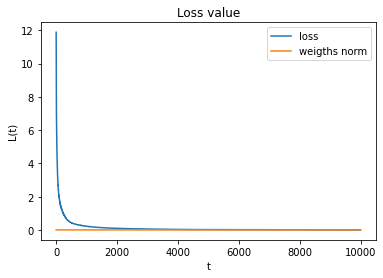

In [10]:
#@title Loss
#import plotly.graph_objs as go
#import plotly

plt.plot(loss_plotter, label="loss")
plt.plot(weigths_norm_plt, label="weigths norm")
plt.title(f"Loss value")
plt.xlabel("t")
plt.ylabel(f"L(t)")
plt.legend()
plt.show()

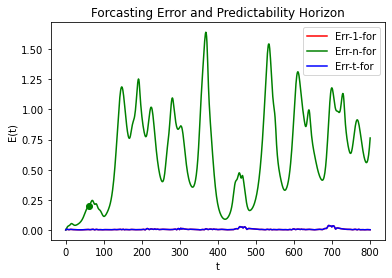

In [11]:
#@title Plot Error

plt.plot(error_plot_1for, label="Err-1-for", color="red")
plt.plot(error_plot_nfor, label="Err-n-for", color="green")
plt.plot(error_plot_tfor, label="Err-t-for", color="blue")
plt.title(f"Forcasting Error and Predictability Horizon")
plt.xlabel("t")
plt.ylabel(f"E(t)")
for k,v in enumerate(error_plot_1for):
    if v>threshold:
        plt.scatter(k, error_plot_1for[k], color="red") # Predictability Horizon for 1-for
        break
for k,v in enumerate(error_plot_nfor):
    if v>threshold:
        plt.scatter(k, error_plot_nfor[k], color="green") # Predictability Horizon for n-for
        break
for k,v in enumerate(error_plot_tfor):
    if v>threshold:
        plt.scatter(k, error_plot_tfor[k], color="blue") # Predictability Horizon for t-for
        break
plt.legend()

plt.show()

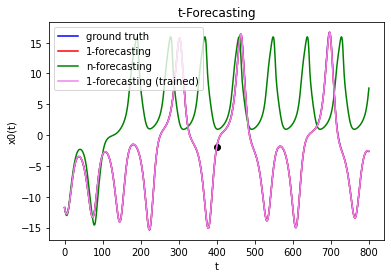

In [12]:
#@title Plot x0 vs t

k=0
plt.title(f"t-Forecasting")
plt.plot(x_sys[:,k], color="blue", label="ground truth")
plt.plot(x_for_1[:,k], color="red", label="1-forecasting")
plt.plot(x_for_n[:,k], color="green",label="n-forecasting")
#if for_hor != "n" and for_hor != 1:
#    plt.plot(x_for_t, color="violet",label=f"{for_hor}-forecasting (trained)")
plt.plot(x_for_t[:,k], color="violet",label=f"{for_hor}-forecasting (trained)")
plt.xlabel("t")
plt.ylabel(f"x{k}(t)")
plt.legend()
plt.scatter(Nt, x_sys[Nt, k], color="black") # training horizon position

plt.show()

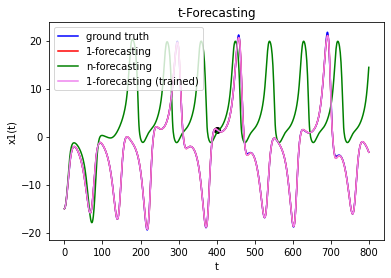

In [13]:
#@title Plot x1 vs t


k=1
plt.title(f"t-Forecasting")
plt.plot(x_sys[:,k], color="blue", label="ground truth")
plt.plot(x_for_1[:,k], color="red", label="1-forecasting")
plt.plot(x_for_n[:,k], color="green",label="n-forecasting")
#if for_hor != "n" and for_hor != 1:
#    plt.plot(x_for_t, color="violet",label=f"{for_hor}-forecasting (trained)")
plt.plot(x_for_t[:,k], color="violet",label=f"{for_hor}-forecasting (trained)")
plt.xlabel("t")
plt.ylabel(f"x{k}(t)")
plt.legend()
plt.scatter(Nt, x_sys[Nt, k], color="black") # training horizon position

plt.show()

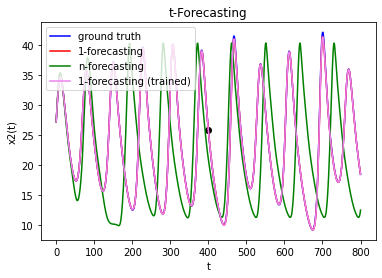

In [14]:
#@title Plot x2 vs t


k=2
plt.title(f"t-Forecasting")
plt.plot(x_sys[:,k], color="blue", label="ground truth")
plt.plot(x_for_1[:,k], color="red", label="1-forecasting")
plt.plot(x_for_n[:,k], color="green",label="n-forecasting")
#if for_hor != "n" and for_hor != 1:
#    plt.plot(x_for_t, color="violet",label=f"{for_hor}-forecasting (trained)")
plt.plot(x_for_t[:,k], color="violet",label=f"{for_hor}-forecasting (trained)")
plt.xlabel("t")
plt.ylabel(f"x{k}(t)")
plt.legend()
plt.scatter(Nt, x_sys[Nt, k], color="black") # training horizon position

plt.show()

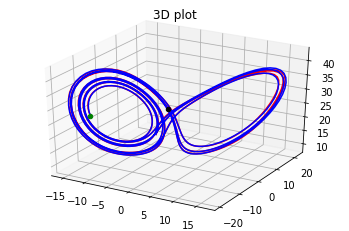

In [15]:
#@title Plot 3D - Ground Truth vs T-forecasting


ax = plt.axes(projection='3d')
ax.plot3D(x_for_t[:,0].numpy(), x_for_t[:,1].numpy(), x_for_t[:,2].numpy(), 'red', label="gnd")
ax.plot3D(x_sys[:,0].numpy(), x_sys[:,1].numpy(), x_sys[:,2].numpy(), 'blue', label="t-for")
plt.title("3D plot")
ax.scatter(x_sys[0,0],x_sys[0,1],x_sys[0,2], color="green") # initial position
ax.scatter(x_sys[Nt,0],x_sys[Nt,1],x_sys[Nt,2], color="black") # training horizon position

plt.show()

# trace2 = go.Scatter3d(
#     x=x_sys[:,0],
#     y=x_sys[:,1],
#     z=x_sys[:,2],
#     mode='lines',
#     name='lines'
# )
# fig = go.Figure(data=[, weigths_norm_plt])
# plotly.offline.iplot(fig, filename='simple-3d-scatter')


In [16]:
#@title Plot 3D  Ground Truth vs T-forcasting


import plotly.graph_objects as go
import pandas as pd
import numpy as np


#x_sys = x_sys.numpy()



d = {'x': x_sys[:,0], 'y': x_sys[:,1], 'z': x_sys[:,2], 'target':'gnd'}
dgnd = pd.DataFrame(data=d)

d = {'x': x_for_t[:,0], 'y': x_for_t[:,1], 'z': x_for_t[:,2], 'target':'t-for'}
dtfor = pd.DataFrame(data=d)

df = pd.concat([dgnd, dtfor])



fig = px.line_3d(df, x="x", y="y", z="z", color="target")#, line_dash="target")


fig.show()


In [17]:
#@title Plot 3D  Ground Truth vs 1-forcasting


import plotly.graph_objects as go
import pandas as pd
import numpy as np


#x_sys = x_sys.numpy()



d = {'x': x_sys[:,0], 'y': x_sys[:,1], 'z': x_sys[:,2], 'target':'gnd'}
dgnd = pd.DataFrame(data=d)

d = {'x': x_for_t[:,0], 'y': x_for_t[:,1], 'z': x_for_1[:,2], 'target':'t-for'}
dtfor = pd.DataFrame(data=d)

df = pd.concat([dgnd, dtfor])



fig = px.line_3d(df, x="x", y="y", z="z", color="target")#, line_dash="target")


fig.show()

In [18]:
#@title Plot 3D  Ground Truth vs N-forcasting

d = {'x': x_sys[:,0], 'y': x_sys[:,1], 'z': x_sys[:,2], 'target':'gnd'}
dgnd = pd.DataFrame(data=d)

d = {'x': x_for_n[:,0], 'y': x_for_n[:,1], 'z': x_for_n[:,2], 'target':'n-for'}
dnfor = pd.DataFrame(data=d)

df = pd.concat([dgnd, dnfor])

fig = px.line_3d(df, x="x", y="y", z="z", color="target")
fig.show()